In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [11]:
# btc_file = '../knn/Bitcoin_01.10.2017-20.03.2025_historical_data_coinmarketcap.csv'
btc_file = '../Bitcoin_data/all_together.csv'

df_btc = pd.read_csv(btc_file, sep=';')

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_df = df_btc.copy()

In [12]:
scaled_df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2014-04-09T00:00:00.000Z,2014-04-09T23:59:59.999Z,2014-04-09T02:06:02.000Z,2014-04-09T21:41:03.000Z,2781,453.177002,455.727997,441.933014,442.725006,13204400.0,5.589580e+09,2014-04-09T23:59:59.999Z
1,2014-04-08T00:00:00.000Z,2014-04-08T23:59:59.999Z,2014-04-08T07:21:02.000Z,2014-04-08T00:26:03.000Z,2781,447.613007,457.424011,446.114014,453.085999,10921600.0,5.718580e+09,2014-04-08T23:59:59.999Z
2,2014-04-07T00:00:00.000Z,2014-04-07T23:59:59.999Z,2014-04-07T00:06:03.000Z,2014-04-07T16:51:03.000Z,2781,461.473999,462.563995,445.122009,449.423004,15616600.0,5.670831e+09,2014-04-07T23:59:59.999Z
3,2014-04-06T00:00:00.000Z,2014-04-06T23:59:59.999Z,2014-04-06T04:46:02.000Z,2014-04-06T13:21:03.000Z,2781,463.397003,466.319000,452.970001,460.498993,10241400.0,5.808861e+09,2014-04-06T23:59:59.999Z
4,2014-04-05T00:00:00.000Z,2014-04-05T23:59:59.999Z,2014-04-05T23:46:02.000Z,2014-04-05T00:46:02.000Z,2781,446.674988,463.571014,444.196991,461.907013,13404500.0,5.824867e+09,2014-04-05T23:59:59.999Z


In [13]:
columns_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']
for col in columns_to_drop:
    if col in scaled_df.columns:
        scaled_df.drop(columns=[col], inplace=True)

if 'timestamp' in scaled_df.columns:
    scaled_df = scaled_df.set_index('timestamp')

feature_columns = ['open', 'high', 'low', 'volume', 'marketCap']
target_column = 'close'

available_feature_cols = [col for col in feature_columns if col in scaled_df.columns]
print(f"Доступні колонки для features: {available_feature_cols}")

if target_column not in scaled_df.columns:
    print(f"Помилка: колонка '{target_column}' не знайдена!")
    exit()

scaled_df[available_feature_cols] = feature_scaler.fit_transform(scaled_df[available_feature_cols])
scaled_df[[target_column]] = target_scaler.fit_transform(scaled_df[[target_column]])

print("Структура даних:")
print(scaled_df.head())
print(f"Shape: {scaled_df.shape}")

Доступні колонки для features: ['open', 'high', 'low', 'volume', 'marketCap']
Структура даних:
                          name      open      high       low     close  \
timestamp                                                                
2014-04-09T23:59:59.999Z  2781  0.003718  0.003641  0.003699  0.003600   
2014-04-08T23:59:59.999Z  2781  0.003668  0.003656  0.003737  0.003693   
2014-04-07T23:59:59.999Z  2781  0.003792  0.003702  0.003728  0.003660   
2014-04-06T23:59:59.999Z  2781  0.003809  0.003736  0.003800  0.003760   
2014-04-05T23:59:59.999Z  2781  0.003660  0.003711  0.003720  0.003772   

                            volume  marketCap  
timestamp                                      
2014-04-09T23:59:59.999Z  0.000038   0.002320  
2014-04-08T23:59:59.999Z  0.000031   0.002378  
2014-04-07T23:59:59.999Z  0.000044   0.002356  
2014-04-06T23:59:59.999Z  0.000029   0.002419  
2014-04-05T23:59:59.999Z  0.000038   0.002426  
Shape: (4399, 7)


In [14]:
def prepare_data(df, window_size=5):
    X, y = [], []
    feature_cols = [col for col in df.columns if col != 'close']
    
    for i in range(len(df) - window_size):
        features = df[feature_cols].iloc[i:i+window_size].values
        target = df['close'].iloc[i+window_size]
        
        X.append(features.flatten())
        y.append(target)
    
    return np.array(X), np.array(y)


In [15]:
class CNNModel(nn.Module):
    def __init__(self, input_length, num_channels=16, kernel_size=3, dropout_rate=0.2):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        conv_out_size = input_length - kernel_size + 1
        self.fc1 = nn.Linear(num_channels * conv_out_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [16]:
def run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                             target_scaler, results_dict, epochs=100, lr=0.001, early_stopping_threshold=0.1, patience=10):
    print(f"Training {model_name}...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        best_loss = float('inf')
        
        train_loss = loss.item()
        train_losses.append(train_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
            
        if train_loss < early_stopping_threshold:
            print(f"Early stopping at epoch {epoch+1} (loss {train_loss:.6f} < {early_stopping_threshold})")
            break

        if train_loss < best_loss - 1e-5:
            best_loss = train_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.6f}")

    
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy()
    
    preds_inv = target_scaler.inverse_transform(preds)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    
    results_dict[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'final_loss': train_losses[-1],
        'model': model,  
        'X_test': X_test,
        'y_test': y_test
    }
    
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print("-" * 50)
    
    return model


In [17]:
results = {}

window_sizes = [5, 10, 15]
hidden_sizes = [(64,), (128,), (64, 32), (128, 64), (256, 128)]
learning_rates = [0.001, 0.01]
epochs_list = [50, 100, 1000]

best_X_test, best_y_test = None, None

print("Початок експериментів з MLP моделями")
print("=" * 60)

experiment_count = 0
total_experiments = len(window_sizes) * len(hidden_sizes) * len(learning_rates) * len(epochs_list)


Початок експериментів з MLP моделями


In [18]:
for window_size in window_sizes:
    print(f"\n Window size: {window_size}")
    
    X, y = prepare_data(scaled_df, window_size=window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    best_X_test, best_y_test = X_test, y_test
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    input_size = X_train.shape[1]  # Для CNN це довжина послідовності

    for lr in learning_rates:
        for epochs in epochs_list:
            experiment_count += 1
            
            model = CNNModel(input_length=input_size)
            model_name = f"CNN_w{window_size}_ch16_ks3_lr{lr}_e{epochs}"
            
            print(f"\n[{experiment_count}/{total_experiments}] {model_name}")
            
            run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                                    target_scaler, results, epochs=epochs, lr=lr)
print("\n" + "=" * 80)
print(" ПІДСУМОК РЕЗУЛЬТАТІВ ВСІХ ЕКСПЕРИМЕНТІВ")
print("=" * 80)



 Window size: 5


Training set shape: (3515, 30)
Test set shape: (879, 30)

[1/90] CNN_w5_ch16_ks3_lr0.001_e50
Training CNN_w5_ch16_ks3_lr0.001_e50...
Epoch 20/50, Loss: 1548.899414
Epoch 20/50, Loss: 1548.899414
Epoch 40/50, Loss: 377.886200
Epoch 40/50, Loss: 377.886200
RMSE: 87581.9597, MAE: 83728.7236
--------------------------------------------------

[2/90] CNN_w5_ch16_ks3_lr0.001_e100
Training CNN_w5_ch16_ks3_lr0.001_e100...
Epoch 20/100, Loss: 3119.898926
Epoch 20/100, Loss: 3119.898926
Epoch 40/100, Loss: 1003.410522
Epoch 40/100, Loss: 1003.410522
Epoch 60/100, Loss: 348.318237
Epoch 60/100, Loss: 348.318237
Epoch 80/100, Loss: 152.845917
Epoch 80/100, Loss: 152.845917
Epoch 100/100, Loss: 86.068451
Epoch 100/100, Loss: 86.068451
RMSE: 78622.7704, MAE: 74273.3939
--------------------------------------------------

[3/90] CNN_w5_ch16_ks3_lr0.001_e1000
Training CNN_w5_ch16_ks3_lr0.001_e1000...
Epoch 20/1000, Loss: 991.678101
Epoch 20/1000, Loss: 991.678101
Epoch 40/1000, Loss: 252.550842
Epoch 4

In [19]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])

print(f"{'Model Name':<40} {'RMSE':<10} {'MAE':<10} {'Final Loss':<12}")
print("-" * 80)

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    final_loss = metrics['final_loss']
    print(f"{model_name:<40} {rmse:<10.4f} {mae:<10.4f} {final_loss:<12.6f}")

best_model = sorted_results[0]
print(f"\n НАЙКРАЩА МОДЕЛЬ: {best_model[0]}")
print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
print(f"   MAE: {best_model[1]['MAE']:.4f}")

print(f"\n АНАЛІЗ ПО WINDOW SIZE:")
for ws in window_sizes:
    ws_results = [(name, metrics) for name, metrics in results.items() if f"_w{ws}_" in name]
    if ws_results:
        best_ws = min(ws_results, key=lambda x: x[1]['RMSE'])
        avg_rmse = np.mean([metrics['RMSE'] for _, metrics in ws_results])
        print(f"Window {ws}: Найкращий RMSE = {best_ws[1]['RMSE']:.4f}, Середній RMSE = {avg_rmse:.4f}")

Model Name                               RMSE       MAE        Final Loss  
--------------------------------------------------------------------------------
CNN_w10_ch16_ks3_lr0.001_e1000           52014.1442 45176.9013 0.396595    
CNN_w15_ch16_ks3_lr0.001_e50             53958.8609 47398.9927 6.488531    
CNN_w15_ch16_ks3_lr0.01_e1000            54671.6815 48208.9058 0.007754    
CNN_w5_ch16_ks3_lr0.001_e1000            55549.1367 49208.9881 0.342205    
CNN_w15_ch16_ks3_lr0.001_e100            56810.3063 50621.3071 2.560845    
CNN_w15_ch16_ks3_lr0.001_e1000           57574.6707 51477.6509 0.098903    
CNN_w10_ch16_ks3_lr0.001_e100            58118.3868 52088.6562 7.856569    
CNN_w5_ch16_ks3_lr0.01_e50               65115.6132 59798.5080 2.156937    
CNN_w15_ch16_ks3_lr0.01_e100             67807.6846 62713.5386 0.061264    
CNN_w10_ch16_ks3_lr0.01_e100             70267.9158 65368.6562 0.024980    
CNN_w10_ch16_ks3_lr0.01_e1000            73393.5911 68717.5410 0.060541    
CNN_w10

--------------------
ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ
--------------------
 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ
 АНАЛІЗ КОРЕЛЯЦІЇ ОЗНАК (ПІРСОН)


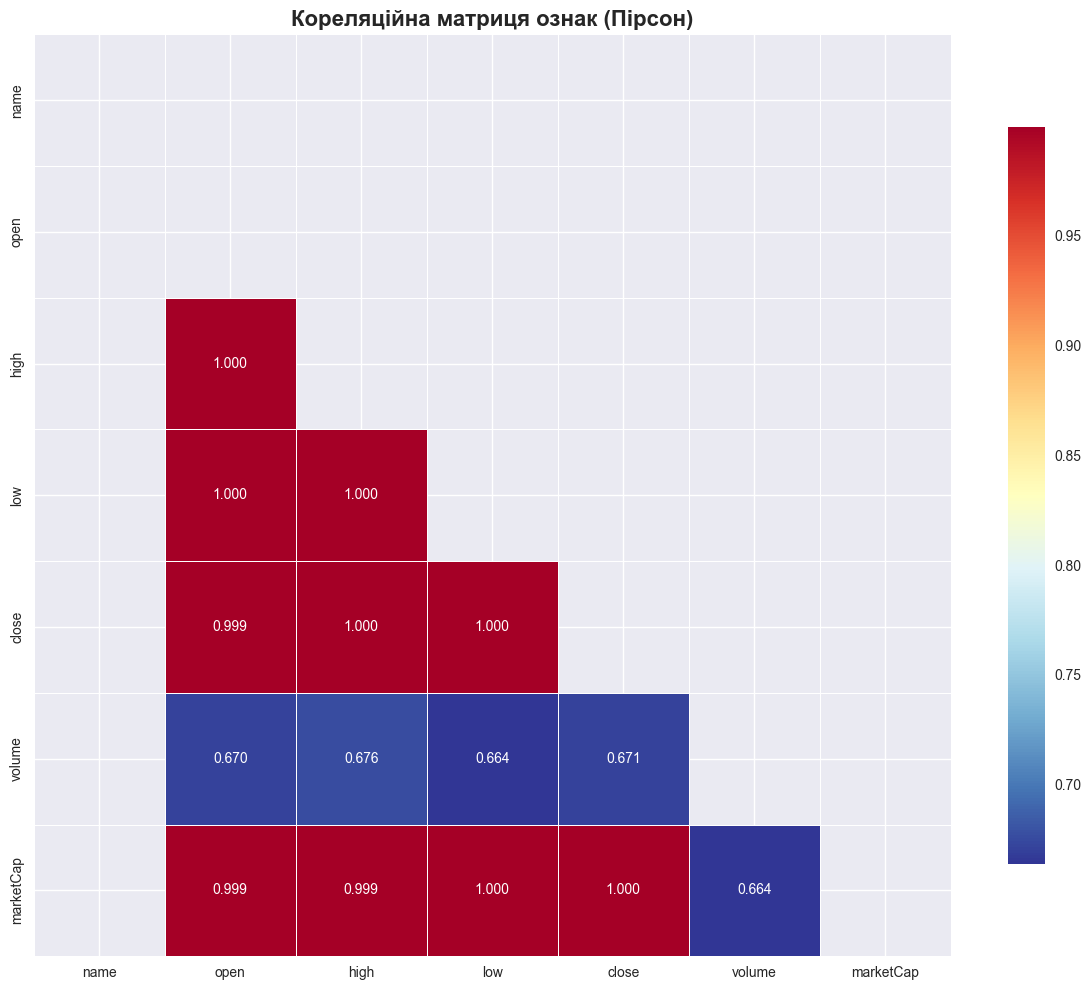


 Найсильніші кореляції:
 1. high         ↔ close       :  1.000
 2. close        ↔ marketCap   :  1.000
 3. open         ↔ high        :  1.000
 4. low          ↔ close       :  1.000
 5. open         ↔ low         :  1.000
 6. low          ↔ marketCap   :  1.000
 7. high         ↔ low         :  1.000
 8. high         ↔ marketCap   :  0.999
 9. open         ↔ close       :  0.999
10. open         ↔ marketCap   :  0.999

 РОЗПОДІЛ ОЗНАК


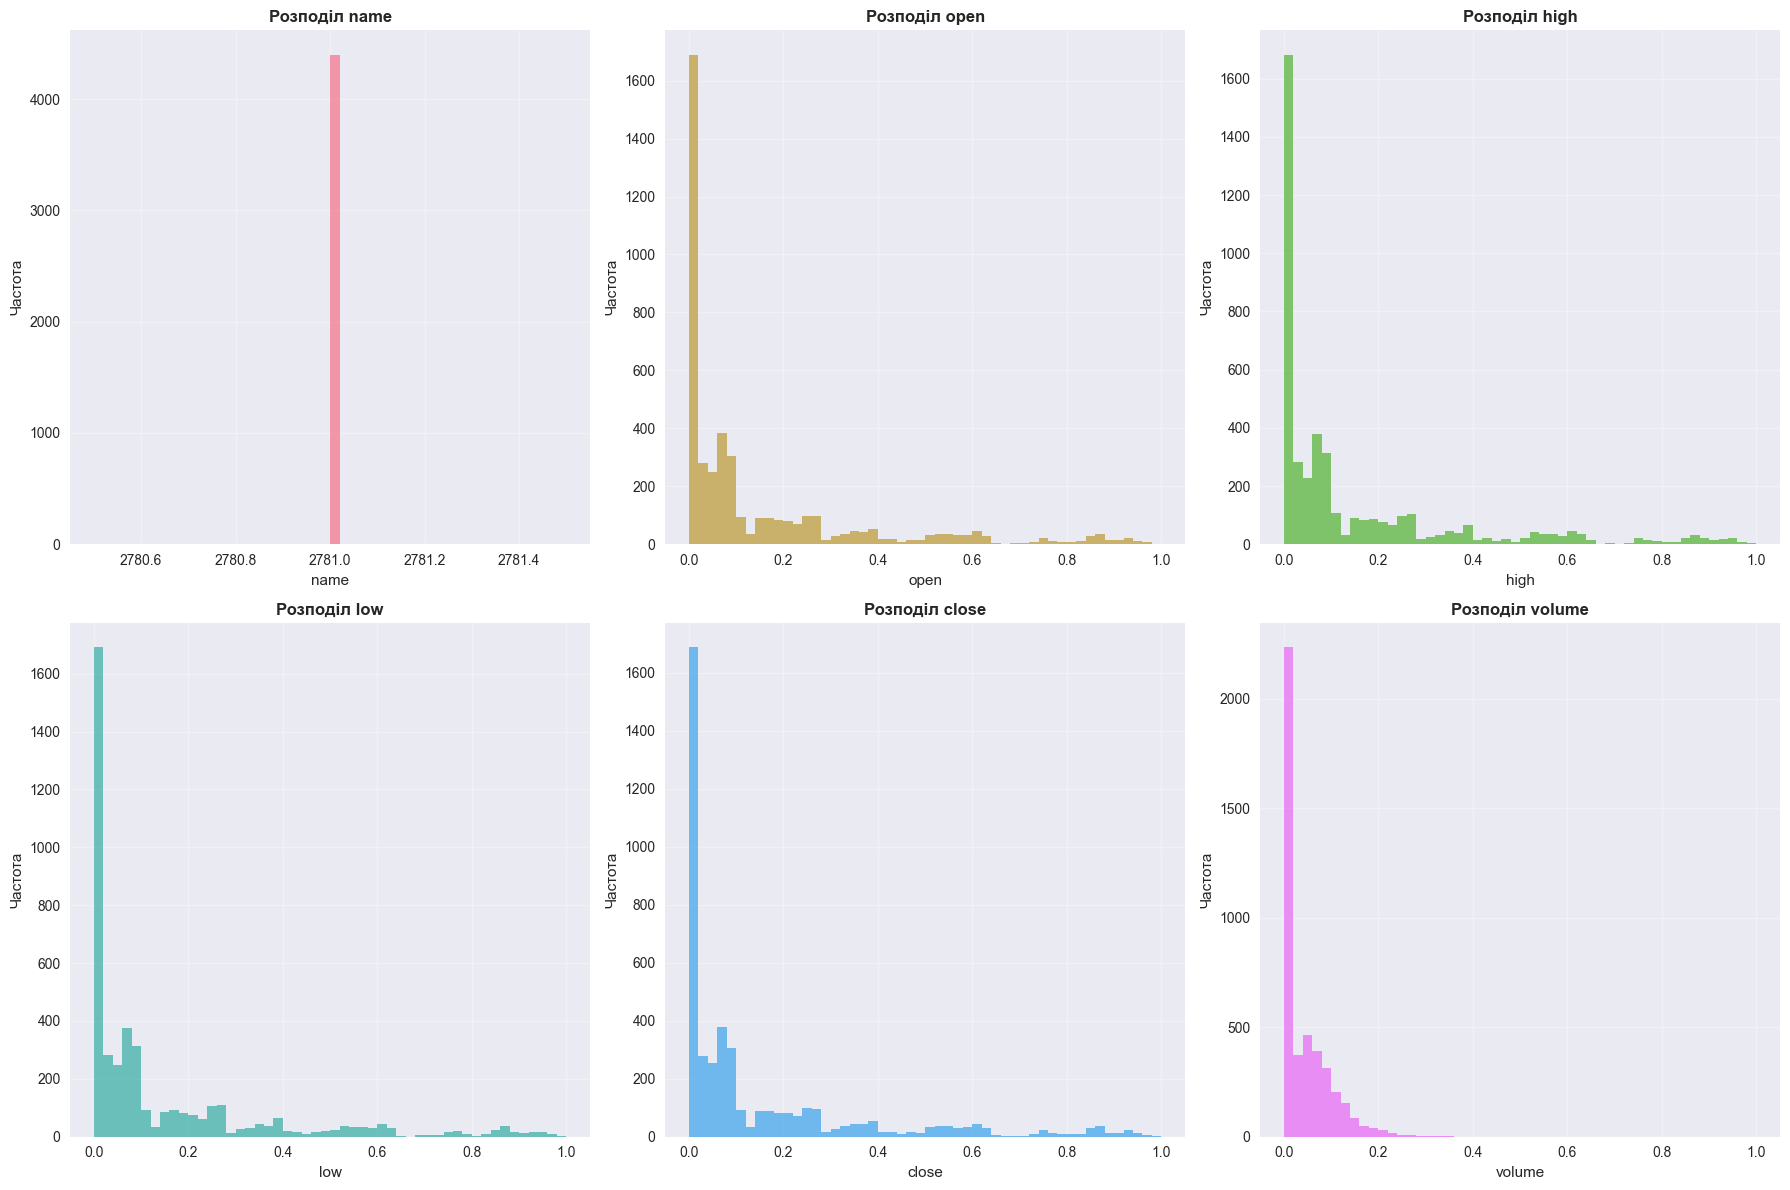


 ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: CNN_w10_ch16_ks3_lr0.001_e1000
 МЕТРИКИ РЕГРЕСІЇ:
RMSE (Root Mean Square Error): 52014.1442
MAE (Mean Absolute Error): 45176.9013
MAPE (Mean Absolute Percentage Error): 74.45%
R² Score: -3.0713
Explained Variance Score: 0.0000


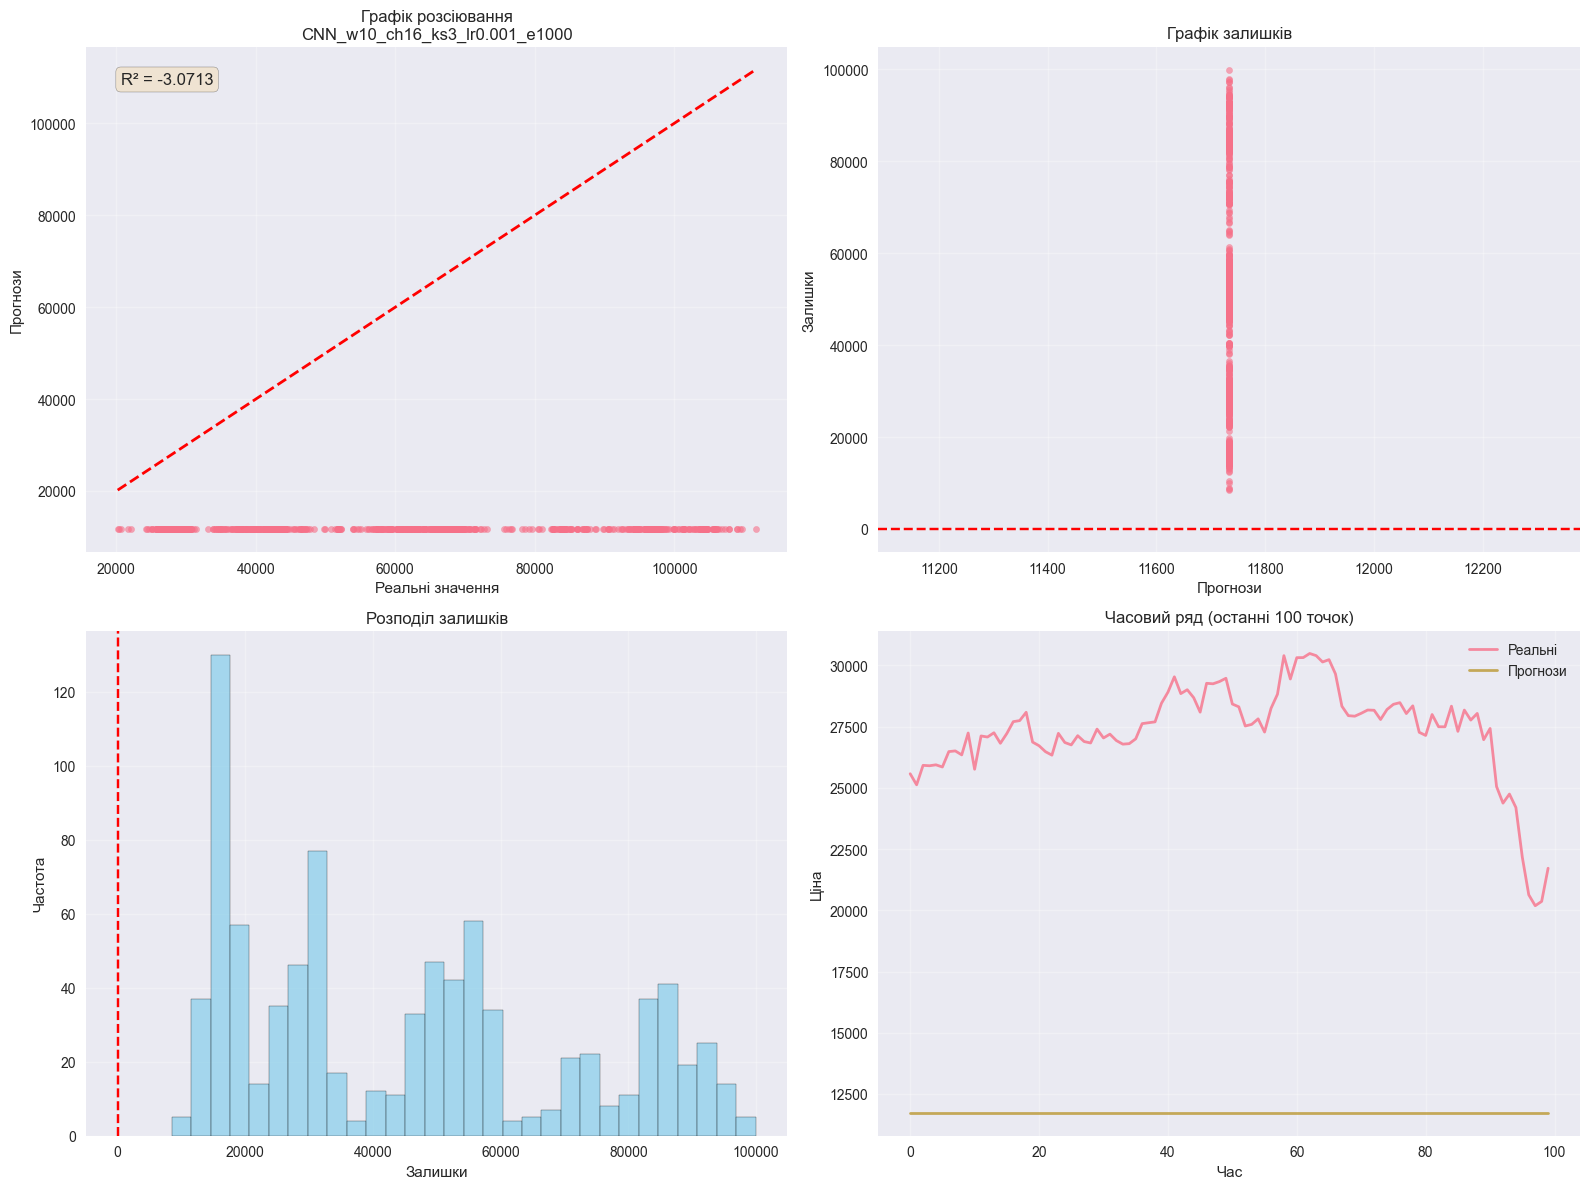


 КЛАСИФІКАЦІЙНІ МЕТРИКИ (Напрямок руху ціни):
Класи: 0 = Спадання, 1 = Зростання
Accuracy: 0.5086
Precision: 0.2586
Recall: 0.5086
F1-Score: 0.3429

 Детальний класифікаційний звіт:
              precision    recall  f1-score   support

    Спадання       0.51      1.00      0.67       446
   Зростання       0.00      0.00      0.00       431

    accuracy                           0.51       877
   macro avg       0.25      0.50      0.34       877
weighted avg       0.26      0.51      0.34       877



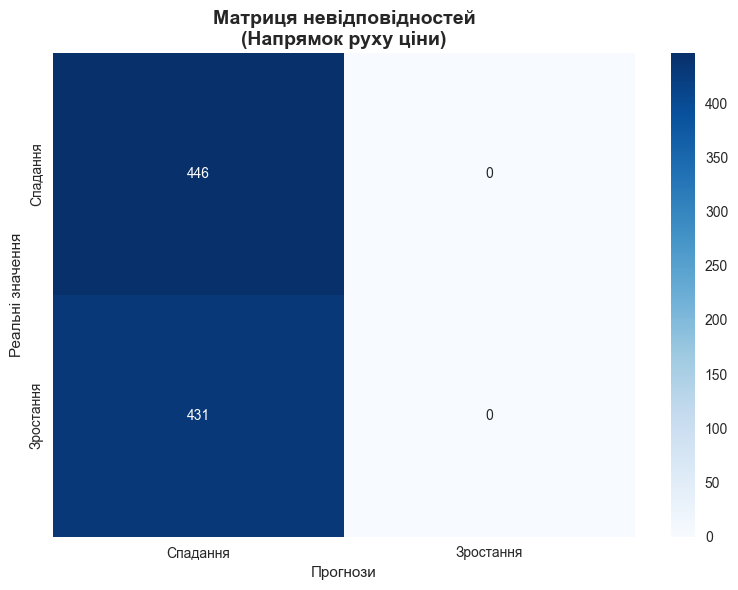


 Інтерпретація матриці невідповідностей:
True Negatives (правильно передбачені спадання): 446
False Positives (помилково передбачені зростання): 0
False Negatives (пропущені зростання): 431
True Positives (правильно передбачені зростання): 0

 ТАБЛИЦЯ ПОРІВНЯННЯ МЕТРИК:
Метрика      Значення   Опис                                    
-----------------------------------------------------------------
Accuracy     0.5086     Частка правильних прогнозів             
Precision    0.2586     Частка правильних позитивних прогнозів  
Recall       0.5086     Частка знайдених позитивних випадків    
F1-Score     0.3429     Гармонічне середнє Precision і Recall   


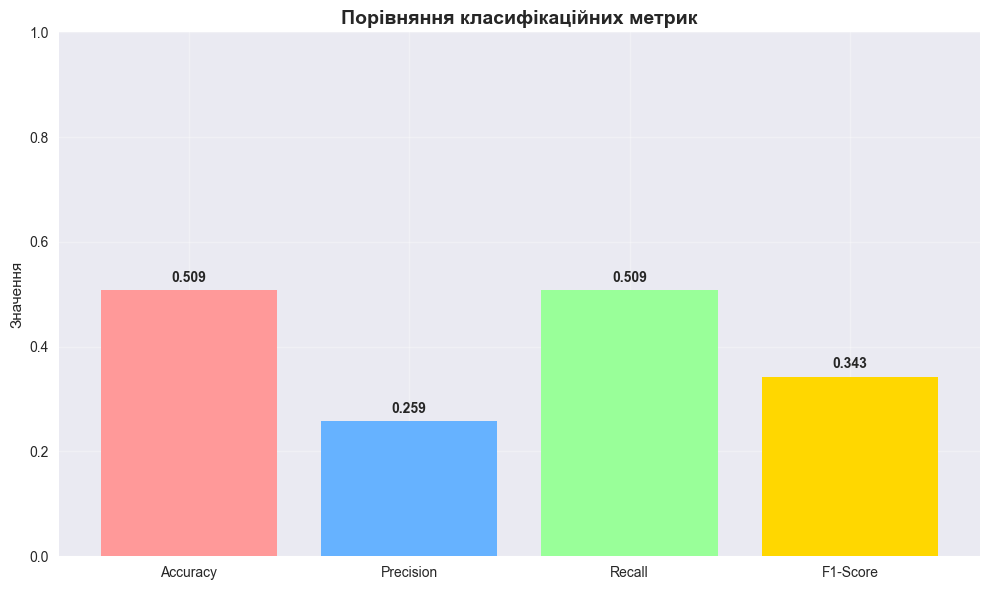


 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
 Статистика параметрів моделі:
Загальна кількість параметрів: 59,585
Навчальні параметри: 59,585

 Статистика вхідних ознак:
       Feature       Mean     Std        Min        Max
0    Feature_0  2781.0000  0.0000  2781.0000  2781.0000
1    Feature_1     0.5101  0.2290     0.2247     1.0000
2    Feature_2     0.5184  0.2330     0.2295     1.0000
3    Feature_3     0.5116  0.2293     0.2266     1.0000
4    Feature_4     0.0874  0.0582     0.0152     0.4252
5    Feature_5     0.5055  0.2316     0.2195     1.0000
6    Feature_6  2781.0000  0.0000  2781.0000  2781.0000
7    Feature_7     0.5100  0.2291     0.2241     1.0000
8    Feature_8     0.5183  0.2330     0.2295     1.0000
9    Feature_9     0.5115  0.2294     0.2266     1.0000
10  Feature_10     0.0874  0.0581     0.0152     0.4252
11  Feature_11     0.5055  0.2316     0.2195     1.0000
12  Feature_12  2781.0000  0.0000  2781.0000  2781.0000
13  Feature_13     0.5099  0.2292     0.2180     1.0000
14  Featu

In [20]:
print("-" * 20)
print("ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ")
print("-" * 20)

best_model_name = sorted_results[0][0]

from ModelAnalyzer import ModelAnalyzer, run_complete_analysis

best_model_name = best_model[0]
model_results = best_model[1]
actual_pytorch_model = model_results['model']

test_data_X = model_results['X_test']
test_data_y = model_results['y_test']

analyzer, analysis_results = run_complete_analysis(
    df=scaled_df,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    best_model=actual_pytorch_model,
    X_test=test_data_X,
    y_test=test_data_y,
    model_name=best_model_name
)